In [1]:
import numpy as np
import pandas as pd
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
import cellpose
from cellpose import utils, io, models, plot
from cellpose.utils import outlines_list, masks_to_outlines
import os, sys
import glob
import cv2
from shapely.geometry import Polygon
import torch
import importlib
importlib.reload(models)
import csv
from pathlib import Path

currentdir = os.path.dirname(os.path.realpath('cell_polygons.ipynb'))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)

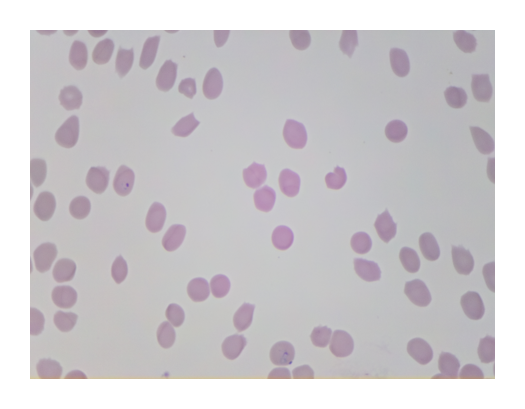

In [2]:
#from NIH Labels (adjust txt to jpeg / png and store in org_files)

def get_jpeg(path):
    list_jpeg = []
    # Delimiter
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".jpeg"):
                jpeg_path = os.path.join(root, file)
                list_jpeg.append(jpeg_path)
    return list_jpeg

org_files = get_jpeg('../data/scan_clean/vgg_test')
org_files

# view 1 image
img = io.imread(org_files[0])
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.axis('off')
plt.show()

In [3]:
imgs = [cv2.imread(img_path) for img_path in org_files]

In [4]:
img_height = 1024
img_width = 1024
img_channels = 3
imgs_red = np.zeros((len(imgs), img_height, img_width, img_channels), dtype=np.uint8)
sizes_imgs_red = []
for idx, img in enumerate(imgs):
    img_red = cv2.resize(img, (img_height, img_width))
    #Append image to numpy array
    imgs_red[idx] = img_red
    #Append image shape to numpy array
    sizes_imgs_red.append([img_red.shape[0], img_red.shape[1]])

In [5]:
imgs_red[0].shape

(1024, 1024, 3)

In [6]:
diameter = 170

In [5]:
# RUN CELLPOSE


# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=True, model_type='cyto')

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# or if you have different types of channels in each image
channels = [[0,1], [0,1], [0,0]]

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended) 
# diameter can be a list or a single number for all images

# you can run all in a list e.g.
# >>> imgs = [io.imread(filename) in files]
# >>> masks, flows, styles, diams = model.eval(imgs, diameter=None, channels=channels)
# >>> io.masks_flows_to_seg(imgs, masks, flows, diams, files, channels)
# >>> io.save_to_png(imgs, masks, flows, files)

# or in a loop
# for chan, img in zip(channels, imgs_red):
masks_all = []

for img in imgs_red:
    chan = [0, 0] # for black and white imgs
    #img = io.imread(filename)
    masks, flows, styles, diams = model.eval(img, 
                                 diameter= diameter, 
                                 channels=chan,
                                 invert = True,
                                 flow_threshold = 1,
                                 #cellprob_threshold = -2,
                                                )

    masks_all.append(masks)
    
    # # save results so you can load in gui
    # io.masks_flows_to_seg(img, masks, flows, diams, filename, chan)

    # # save results as png
    # io.save_to_png(img, masks, flows, filename)
    
    # DISPLAY RESULTS

    fig = plt.figure(figsize=(12,5))
    plot.show_segmentation(fig, img, masks, flows[0], channels=chan)
    plt.tight_layout()
    plt.show()

TORCH CUDA version not installed/working.
>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 124.89s; flow+mask computation 3.12
estimated masks for 1 image(s) in 128.12 sec
>>>> TOTAL TIME 128.13 sec


In [7]:
#outlines_ls = outlines_list(masks)

def outlines_to_x_y(outlines):
    arr_x = []
    arr_y = []
    for cell in outlines:
        arr_x.append(cell.flatten()[::2])
        arr_y.append(cell.flatten()[1::2])
    return arr_x, arr_y

#x, y = outlines_to_x_y(outlines_ls)

#len(x)

In [8]:
via_region = pd.read_csv('../data/vgg_annotations/via_2_region_data.csv')
via_region_temp = pd.read_csv('../data/vgg_annotations/via_2_region_data.csv')
via_region

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,2021-03-05_15-50-16_800_0_5562.jpeg,14118191,{},2,0,"{""name"":""polygon"",""all_points_x"":[2608,2542,25...","{""RBC"":""infected""}"
1,2021-03-05_15-50-16_800_0_5562.jpeg,14118191,{},2,1,"{""name"":""polygon"",""all_points_x"":[1633,1665,16...","{""RBC"":""uninfected""}"


In [9]:
img_len = len(imgs_red)
model = models.Cellpose(gpu=True, model_type='cyto')
masks_all = []

for i in range(img_len):
    chan = [0, 0] # for black and white imgs
    masks, flows, styles, diams = model.eval(img, 
                                 diameter= diameter, 
                                 channels=chan,
                                 invert = True,
                                 flow_threshold = 1)
    masks_all.append(masks)
    outlines_ls = outlines_list(masks_all[i])
    out_len = len(outlines_ls)
    x, y = outlines_to_x_y(outlines_ls)
    for j in range(out_len):
        via_region_temp.loc[j,['filename']] = org_files[i].split("/")[-1]
        via_region_temp.loc[j,['file_size']] = Path(org_files[i]).stat().st_size
        via_region_temp.loc[j,['file_attributes']] = '{}'
        via_region_temp.loc[j,['region_count']] = out_len
        via_region_temp.loc[j,['region_id']] = 1
        via_region_temp.loc[j,['file_size']] = Path(org_files[i]).stat().st_size
        via_region_temp.loc[j,['region_shape_attributes']] = str("{\"name\":\"poly\",\"all_points_x\":"+str(x[j])+",\"all_points_y\":"+str(y[j])+"}")
        via_region_temp.loc[j,['region_attributes']] = '{\"RBC\":\"uninfected\"}'
        #append locced DF to main df to bypass overriding
    via_region.append(via_region_temp)
via_region

TORCH CUDA version not installed/working.
>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 84.66s; flow+mask computation 3.02
estimated masks for 1 image(s) in 88.34 sec
>>>> TOTAL TIME 88.34 sec
processing 1 image(s)
time spent: running network 66.61s; flow+mask computation 2.74
estimated masks for 1 image(s) in 70.45 sec
>>>> TOTAL TIME 70.46 sec


,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,2021-03-05_15-50-16_800_0_5562.jpeg,14118191,{},2,0,"{""name"":""polygon"",""all_points_x"":[2608,2542,25...","{""RBC"":""infected""}"
1,2021-03-05_15-50-16_800_0_5562.jpeg,14118191,{},2,1,"{""name"":""polygon"",""all_points_x"":[1633,1665,16...","{""RBC"":""uninfected""}"


In [80]:
Path(org_files[0]).stat().st_size

14123252

In [ ]:
#for index, row in df_merged.iterrows():
def vgg_html(row):
    global counter, region_id, previous_row, dict_overlay_glob
    if row.region_shape_attributes == 0:  
        size_org = dict_org_wh[row.org_img]
        size_cut = dict_cut_wh[row.cut_img]
        org_w, org_h = size_org[1], size_org[0]
        cut_w, cut_h = size_cut[1], size_cut[0]

        cuts_w, cuts_h = majority_vote[row.org_img][0], majority_vote[row.org_img][1]
        diag_cut = math.sqrt( (cut_w * cuts_w) **2 +  (cut_h * cuts_h) **2)
        diag_org_cut = math.sqrt( (org_w ) **2 +  (org_h ) **2)
        scale = diag_cut / diag_org_cut
        #color = np.median(imReference, axis=(0, 1))
        print(row.cut_img)
        
    
        if dict_gt[row.cut_img] is not None and row.org_img != 'test_set_59496f73579e529fdea8af00' and row.org_img != 'test_set_59450ede579e529fdea8aefe':
            x1, x2, y1, y2 = row.x1, row.x2, row.y1, row.y2
            row.x1_scl_off = int(round(x1 / scale + row.x1_bayes_offset))
            row.x2_scl_off = int(round(x2 / scale + row.x1_bayes_offset))
            row.y1_scl_off = int(round(y1 / scale + row.y1_bayes_offset))
            row.y2_scl_off = int(round(y2 / scale + row.y1_bayes_offset))

        elif row.org_img == 'test_set_59496f73579e529fdea8af00' or row.org_img == 'test_set_59450ede579e529fdea8aefe':
            x1, x2, y1, y2 = row.x1, row.x2, row.y1, row.y2
            row.x1_scl_off = int(round(x1 / scale + row.x1_offset))
            row.x2_scl_off = int(round(x2 / scale + row.x1_offset))
            row.y1_scl_off = int(round(y1 / scale + row.y1_offset))
            row.y2_scl_off = int(round(y2 / scale + row.y1_offset))

        row.region_shape_attributes = str("{\"name\":\"poly\",\"all_points_x\":" + str(row.x1_scl_off) + \
                                          ",\"all_points_y\":" + str(row.y1_scl_off) + \
                                          ",\"width\":" + str(row.x2_scl_off - row.x1_scl_off) +\
                                          ",\"height\":" + str(row.y2_scl_off - row.y1_scl_off) + "}")
    counter += 1
    
    if row.org_img == previous_row:
        region_id += 1
        row.region_id = region_id
    else:
        region_id = 0
        row.region_id = region_id
    
    
    row.filename = row.org_img + ".jpg"
    row.file_attributes = "{}"
    row.region_attributes = "{\"uninfected\"}"
        
    previous_row = row.org_img

    print(counter)
    return row